In [25]:
import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import os
#!pip install neurokit2
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]  # Bigger images

# Load lists for datafiles
from lists import list_str, datafiles_raw_SIT, datafiles_raw_GAZE

In [26]:
# Cosine interpolation
from math import pi,cos

def cosine(x, x1, x2):
    T = x2-x1
    val = 0.5 * cos(2.0 * pi * (x - x1) / T)
    return val

def rpeaks_cosine_interpolation(rpeaks):
    rpeaks_idx = [i for i, x in enumerate(rpeaks) if x == 1]
    rpeaks_cip = [np.nan]*rpeaks_idx[0]
    for i in range(len(rpeaks_idx)):
        if i == len(rpeaks_idx)-1:
            break
        x1 = rpeaks_idx[i]
        x2 = rpeaks_idx[i+1]
        T = x2-x1
        f = lambda x: cosine(x, x1, x2)
        x = np.linspace(x1,x2,T)
        y = [f(x) for x in x]

        rpeaks_cip = rpeaks_cip + y
    rpeaks_cip = rpeaks_cip + [np.nan]*(len(rpeaks)-rpeaks_idx[-1])
    return rpeaks_cip # keep in mind: there are nans at the start and end

In [27]:
# Set sampling rate for neurokit2
sampling_rate=2000

In [28]:
# Get data for SIT
ecg_raw = [None]*len(list_str)
ecg = [None]*len(list_str)
rpeaks = [None]*len(list_str)
data = [None]*len(list_str)

for i in range(len(list_str)):
    # Load ECG-data as a list
    ecg_raw[i] = np.load(datafiles_raw_SIT[i])
    ecg_raw[i] = pd.Series(ecg_raw[i].ravel()) #.ravel() to remove redundant parentheses
    # Clean, normalize and evaluate data
    ecg[i] = nk.ecg_clean(ecg_raw[i], sampling_rate=sampling_rate, method="neurokit")
    print(nk.ecg_quality(ecg[i], rpeaks=None, sampling_rate=sampling_rate, method="zhao2018", approach="fuzzy"))
    # Get r-peaks as a binary time series
    rpeaks[i] = nk.ecg_peaks(ecg[i], sampling_rate=sampling_rate)
    rpeaks[i] = rpeaks[i][0]
    rpeaks[i] = rpeaks[i]["ECG_R_Peaks"]
    # Trigonometric interpolation of r-peaks
    data[i] = rpeaks_cosine_interpolation(rpeaks[i])
    # Trim data to get rid of nans
    data[i] = data[i][2*sampling_rate:300*sampling_rate-2*sampling_rate]
    # Downsampling to 50 Hz
    data[i] = data[i][::40]
    data[i] = np.array(data[i], dtype = "float32")

data = np.array(data)
np.save("data/data_sit.npy", data)
data.shape

Excellent
Barely acceptable
Excellent
Excellent


(4, 14800)

In [29]:
# Get data for GAZE
ecg_raw = [None]*len(list_str)
ecg = [None]*len(list_str)
rpeaks = [None]*len(list_str)
data = [None]*len(list_str)

for i in range(len(list_str)):
    # Load ECG-data as a list
    ecg_raw[i] = np.load(datafiles_raw_GAZE[i])
    ecg_raw[i] = pd.Series(ecg_raw[i].ravel()) #.ravel() to remove redundant parentheses
    # Clean, normalize and evaluate data
    ecg[i] = nk.ecg_clean(ecg_raw[i], sampling_rate=sampling_rate, method="neurokit")
    print(nk.ecg_quality(ecg[i], rpeaks=None, sampling_rate=sampling_rate, method="zhao2018", approach="fuzzy"))
    # Get r-peaks as a binary time series
    rpeaks[i] = nk.ecg_peaks(ecg[i], sampling_rate=sampling_rate)
    rpeaks[i] = rpeaks[i][0]
    rpeaks[i] = rpeaks[i]["ECG_R_Peaks"]
    # Trigonometric interpolation of r-peaks
    data[i] = rpeaks_cosine_interpolation(rpeaks[i])
    # Trim data to get rid of nans
    data[i] = data[i][2*sampling_rate:300*sampling_rate-2*sampling_rate]
    # Downsampling to 50 Hz
    data[i] = data[i][::40]
    data[i] = np.array(data[i], dtype = "float32")

data = np.array(data)
np.save("data/data_gaze.npy", data)
data.shape

Excellent
Excellent
Excellent
Excellent


(4, 14800)

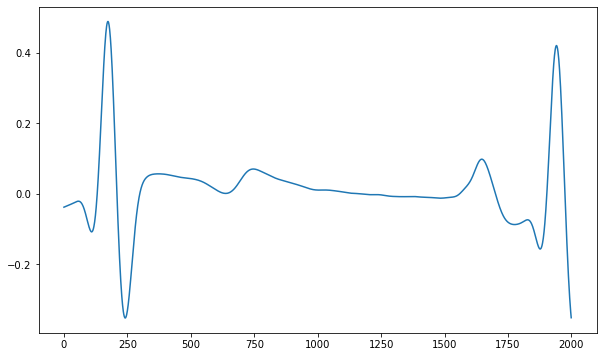

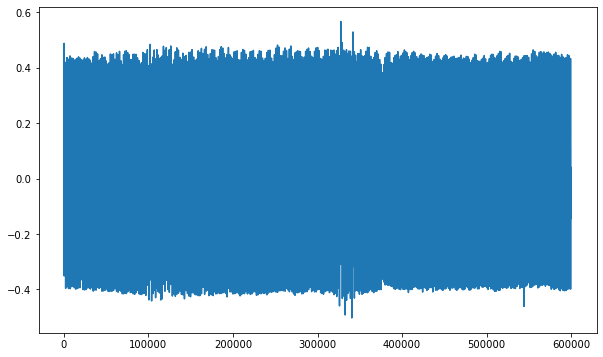

In [129]:
# Show sample data
rpeaks[1].sum(axis=0)

plt.figure(1)
plt.plot(ecg[0][0:sampling_rate])

plt.figure(2)
plt.plot(ecg[0])

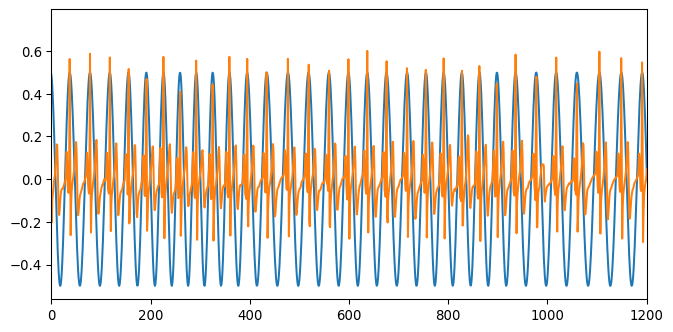

In [130]:
xlim1 = 0*sampling_rate/40
xlim2 = 24*sampling_rate/40

fig = plt.figure(figsize=(8,4), dpi=96)

plt.xlim(xlim1, xlim2)

plt.plot(data[2])
plt.plot(ecg[2][2*sampling_rate::40])#[sampling_rate*6:])

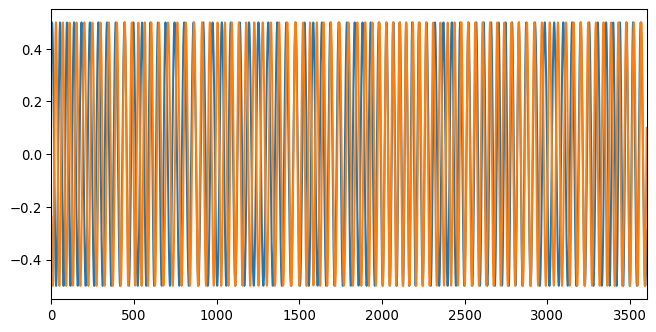

In [131]:
fig = plt.figure(figsize=(8,4), dpi=96)

plt.xlim(xlim1, xlim2*3)
# plt.plot(ibi_time_1)
test = np.array(data[0])

plt.plot(data[1])
plt.plot(data[3])

In [132]:
np.std(data)

0.3536773193746808

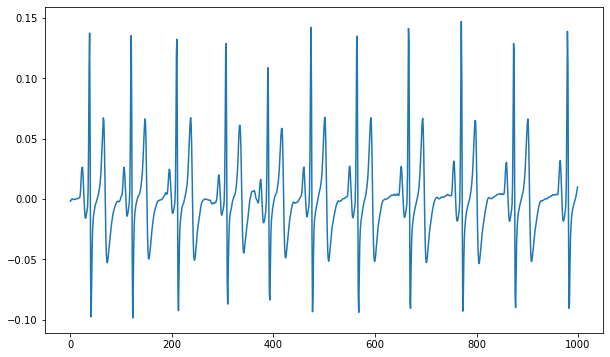

In [10]:
plt.plot(ecg_clean[1][:1000])

In [133]:
a = np.load(r"data_0.npy")
b = np.load(r"data_1.npy")
# >>> d = {'col1': [1, 2], 'col2': [3, 4]}
# >>> df = pd.DataFrame(data=d)
d = {"S1_Joy":a,"S2_Joy":b}
df = pd.DataFrame(data=d)
df

FileNotFoundError: [Errno 2] No such file or directory: 'data_0.npy'